In [3]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [4]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 
NPY_INPUT_DIR = '../data/extracted_features/combined_ML/harvey/'
NPY_OUTPUT_DIR = '../data/resultsML/harvey/'

NUM_TESTS = 25

HIDDEN_DIM0 = 79
NUM_LAYERS0 = 1
BIDIRECTIONAL = False
LEARNING_RATE0 =  0.013912384828252015
IMAGE_HIDDEN= 152
DECAY_FACTOR0 = 0.336704203451307
EPOCH0 = 3

HIDDEN_DIM1 = 265
NUM_LAYERS1 = 2
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.02767144691683026
MOMENTUM1= 0.9
DECAY_FACTOR1 =  0.23481790500794192
EPOCH1 = 4

HIDDEN_DIM2 = 118
NUM_LAYERS2 = 1
ACTIVATION2 = torch.sigmoid
LEARNING_RATE2 =   0.01660885743965316
MOMENTUM2= 0.9
DECAY_FACTOR2 =  0.5073025153847034
EPOCH2 = 4



# LSTM -------------------------------------------------------------------*

In [5]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test, X_img_train, X_img_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, img_hidden_dim = IMAGE_HIDDEN,
                          num_layers = NUM_LAYERS0, bidirectional = BIDIRECTIONAL,
                          learning_rate = LEARNING_RATE0,decay_factor = DECAY_FACTOR0)
        model.learn(X_train, X_img_train, y_train, epochs=EPOCH0)
        
        # evaluate
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, X_img_test, y_test)
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = model.get_accuracy_graph(X_test, X_img_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [6]:
# load data from files
X_seq_img_train = np.load(NPY_INPUT_DIR + 'images_lstm_train.npz', allow_pickle=True)
X_seq_img_test = np.load(NPY_INPUT_DIR + 'images_lstm_test.npz', allow_pickle=True)

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))


# build lists with features concatenated
# img feat
X_raw_img_train = []
for i in range(len(y_train)):
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_raw_img_train.append(hist[j])

img_scaler = StandardScaler()
X_img_fit_train = np.concatenate(X_raw_img_train) # a stack of all image feat
img_scaler.fit(X_img_fit_train)

# now build list of list of normalized 2d matricies representing all img in a tweet
X_img_train = []
for i in range(len(y_train)):
    X_i_img = []
    file = X_seq_img_train.files[i]
    hist = X_seq_img_train[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_train.append(X_i_img)
    
X_img_test = []
for i in range(len(y_test)):
    X_i_img = []
    file = X_seq_img_test.files[i]
    hist = X_seq_img_test[file] # an array of objects with each object being a 2d matrix of all img in a tweet
    for j in range(hist.shape[0]): # for each tweet in sequence
        X_i_img.append(torch.Tensor(img_scaler.transform(hist[j])))
    X_img_test.append(X_i_img)

# lang feat
X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


Strating ************************************************* 0
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.462
[1,   400] loss: 0.415
[1,   600] loss: 0.383
[1,   800] loss: 0.444
[1,  1000] loss: 0.342
[1,  1200] loss: 0.422
[1,  1400] loss: 0.372
[1,  1600] loss: 0.424
[1,  1800] loss: 0.438
[1,  2000] loss: 0.346
[1,  2200] loss: 0.440
[1,  2400] loss: 0.297
[1,  2600] loss: 0.426
[1,  2800] loss: 0.250
[1,  3000] loss: 0.391
[1,  3200] loss: 0.351
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.171
[2,   400] loss: 0.239
[2,   600] loss: 0.164
[2,   800] loss: 0.159
[2,  1000] loss: 0.166
[2,  1200] loss: 0.215
[2,  1400] loss: 0.239
[2,  1600] loss: 0.221
[2,  1800] loss: 0.201
[2,  2000] loss: 0.130
[2,  2200] loss: 0.197
[2,  2400] loss: 0.151
[2,  2600] loss: 0.164
[2,  2800] loss: 0.163
[2,  3000] loss: 0.200
[2,  3200] loss: 0.182
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.078
[3,   400] loss: 0.077
[3,   600] loss: 

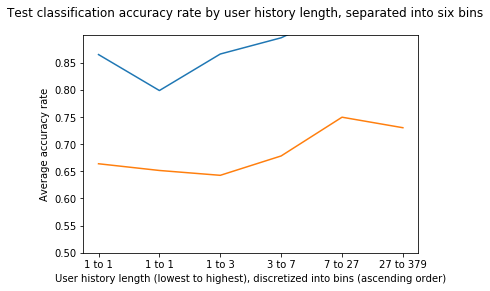

Strating ************************************************* 1
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.461
[1,   400] loss: 0.416
[1,   600] loss: 0.389
[1,   800] loss: 0.439
[1,  1000] loss: 0.342
[1,  1200] loss: 0.436
[1,  1400] loss: 0.367
[1,  1600] loss: 0.390
[1,  1800] loss: 0.441
[1,  2000] loss: 0.369
[1,  2200] loss: 0.443
[1,  2400] loss: 0.297
[1,  2600] loss: 0.398
[1,  2800] loss: 0.245
[1,  3000] loss: 0.383
[1,  3200] loss: 0.362
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.149
[2,   400] loss: 0.243
[2,   600] loss: 0.151
[2,   800] loss: 0.155
[2,  1000] loss: 0.177
[2,  1200] loss: 0.206
[2,  1400] loss: 0.218
[2,  1600] loss: 0.216
[2,  1800] loss: 0.216
[2,  2000] loss: 0.112
[2,  2200] loss: 0.180
[2,  2400] loss: 0.162
[2,  2600] loss: 0.150
[2,  2800] loss: 0.171
[2,  3000] loss: 0.203
[2,  3200] loss: 0.178
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.077
[3,   400] loss: 0.075
[3,   600] loss: 

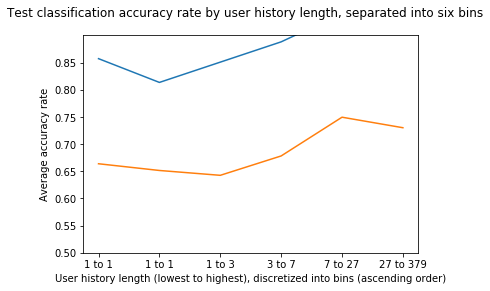

Strating ************************************************* 2
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.464
[1,   400] loss: 0.405
[1,   600] loss: 0.389
[1,   800] loss: 0.439
[1,  1000] loss: 0.349
[1,  1200] loss: 0.414
[1,  1400] loss: 0.373
[1,  1600] loss: 0.407
[1,  1800] loss: 0.422
[1,  2000] loss: 0.365
[1,  2200] loss: 0.443
[1,  2400] loss: 0.297
[1,  2600] loss: 0.408
[1,  2800] loss: 0.252
[1,  3000] loss: 0.390
[1,  3200] loss: 0.342
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.157
[2,   400] loss: 0.242
[2,   600] loss: 0.166
[2,   800] loss: 0.158
[2,  1000] loss: 0.161
[2,  1200] loss: 0.198
[2,  1400] loss: 0.213
[2,  1600] loss: 0.226
[2,  1800] loss: 0.203
[2,  2000] loss: 0.118
[2,  2200] loss: 0.205
[2,  2400] loss: 0.156
[2,  2600] loss: 0.155
[2,  2800] loss: 0.151
[2,  3000] loss: 0.184
[2,  3200] loss: 0.186
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.073
[3,   400] loss: 0.068
[3,   600] loss: 

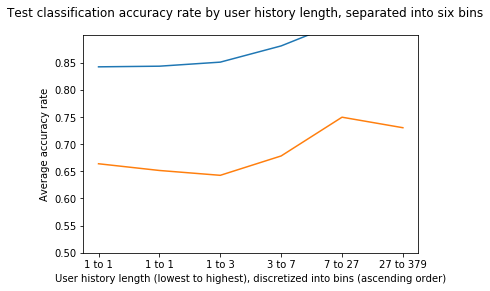

Strating ************************************************* 3
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.456
[1,   400] loss: 0.417
[1,   600] loss: 0.383
[1,   800] loss: 0.452
[1,  1000] loss: 0.338
[1,  1200] loss: 0.423
[1,  1400] loss: 0.372
[1,  1600] loss: 0.414
[1,  1800] loss: 0.434
[1,  2000] loss: 0.361
[1,  2200] loss: 0.434
[1,  2400] loss: 0.297
[1,  2600] loss: 0.428
[1,  2800] loss: 0.260
[1,  3000] loss: 0.391
[1,  3200] loss: 0.347
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.156
[2,   400] loss: 0.243
[2,   600] loss: 0.162
[2,   800] loss: 0.160
[2,  1000] loss: 0.172
[2,  1200] loss: 0.211
[2,  1400] loss: 0.220
[2,  1600] loss: 0.213
[2,  1800] loss: 0.201
[2,  2000] loss: 0.110
[2,  2200] loss: 0.201
[2,  2400] loss: 0.143
[2,  2600] loss: 0.141
[2,  2800] loss: 0.151
[2,  3000] loss: 0.183
[2,  3200] loss: 0.174
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.074
[3,   400] loss: 0.074
[3,   600] loss: 

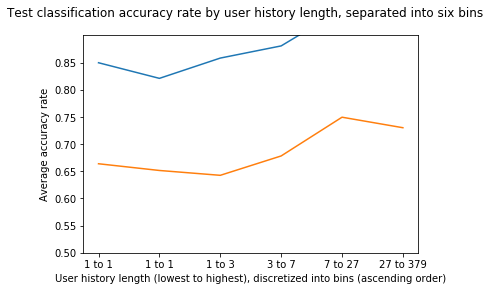

Strating ************************************************* 4
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.415
[1,   600] loss: 0.386
[1,   800] loss: 0.452
[1,  1000] loss: 0.335
[1,  1200] loss: 0.437
[1,  1400] loss: 0.358
[1,  1600] loss: 0.395
[1,  1800] loss: 0.443
[1,  2000] loss: 0.374
[1,  2200] loss: 0.413
[1,  2400] loss: 0.304
[1,  2600] loss: 0.413
[1,  2800] loss: 0.243
[1,  3000] loss: 0.388
[1,  3200] loss: 0.359
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.167
[2,   400] loss: 0.222
[2,   600] loss: 0.142
[2,   800] loss: 0.147
[2,  1000] loss: 0.155
[2,  1200] loss: 0.205
[2,  1400] loss: 0.216
[2,  1600] loss: 0.219
[2,  1800] loss: 0.208
[2,  2000] loss: 0.113
[2,  2200] loss: 0.194
[2,  2400] loss: 0.140
[2,  2600] loss: 0.162
[2,  2800] loss: 0.167
[2,  3000] loss: 0.188
[2,  3200] loss: 0.191
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.085
[3,   400] loss: 0.074
[3,   600] loss: 

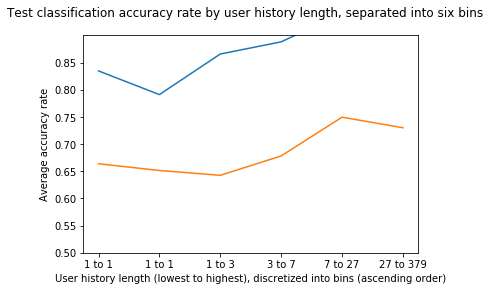

Strating ************************************************* 5
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.462
[1,   400] loss: 0.410
[1,   600] loss: 0.380
[1,   800] loss: 0.434
[1,  1000] loss: 0.342
[1,  1200] loss: 0.435
[1,  1400] loss: 0.376
[1,  1600] loss: 0.396
[1,  1800] loss: 0.423
[1,  2000] loss: 0.369
[1,  2200] loss: 0.436
[1,  2400] loss: 0.295
[1,  2600] loss: 0.416
[1,  2800] loss: 0.255
[1,  3000] loss: 0.414
[1,  3200] loss: 0.339
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.159
[2,   400] loss: 0.229
[2,   600] loss: 0.170
[2,   800] loss: 0.171
[2,  1000] loss: 0.164
[2,  1200] loss: 0.194
[2,  1400] loss: 0.221
[2,  1600] loss: 0.227
[2,  1800] loss: 0.213
[2,  2000] loss: 0.118
[2,  2200] loss: 0.189
[2,  2400] loss: 0.142
[2,  2600] loss: 0.148
[2,  2800] loss: 0.154
[2,  3000] loss: 0.201
[2,  3200] loss: 0.177
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.076
[3,   400] loss: 0.082
[3,   600] loss: 

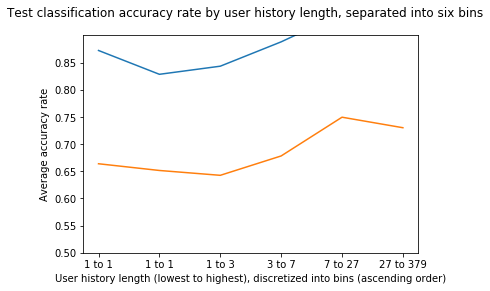

Strating ************************************************* 6
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.455
[1,   400] loss: 0.408
[1,   600] loss: 0.386
[1,   800] loss: 0.446
[1,  1000] loss: 0.339
[1,  1200] loss: 0.434
[1,  1400] loss: 0.377
[1,  1600] loss: 0.401
[1,  1800] loss: 0.428
[1,  2000] loss: 0.374
[1,  2200] loss: 0.448
[1,  2400] loss: 0.292
[1,  2600] loss: 0.423
[1,  2800] loss: 0.245
[1,  3000] loss: 0.391
[1,  3200] loss: 0.348
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.145
[2,   400] loss: 0.233
[2,   600] loss: 0.150
[2,   800] loss: 0.145
[2,  1000] loss: 0.148
[2,  1200] loss: 0.183
[2,  1400] loss: 0.214
[2,  1600] loss: 0.224
[2,  1800] loss: 0.198
[2,  2000] loss: 0.112
[2,  2200] loss: 0.191
[2,  2400] loss: 0.126
[2,  2600] loss: 0.155
[2,  2800] loss: 0.154
[2,  3000] loss: 0.173
[2,  3200] loss: 0.186
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.073
[3,   400] loss: 0.073
[3,   600] loss: 

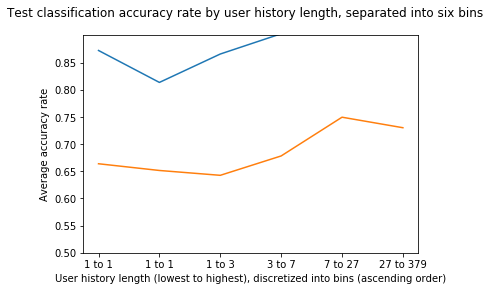

Strating ************************************************* 7
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.456
[1,   400] loss: 0.417
[1,   600] loss: 0.384
[1,   800] loss: 0.436
[1,  1000] loss: 0.344
[1,  1200] loss: 0.428
[1,  1400] loss: 0.365
[1,  1600] loss: 0.404
[1,  1800] loss: 0.444
[1,  2000] loss: 0.365
[1,  2200] loss: 0.430
[1,  2400] loss: 0.308
[1,  2600] loss: 0.430
[1,  2800] loss: 0.253
[1,  3000] loss: 0.380
[1,  3200] loss: 0.360
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.174
[2,   400] loss: 0.225
[2,   600] loss: 0.156
[2,   800] loss: 0.160
[2,  1000] loss: 0.168
[2,  1200] loss: 0.192
[2,  1400] loss: 0.231
[2,  1600] loss: 0.192
[2,  1800] loss: 0.202
[2,  2000] loss: 0.124
[2,  2200] loss: 0.192
[2,  2400] loss: 0.151
[2,  2600] loss: 0.165
[2,  2800] loss: 0.164
[2,  3000] loss: 0.190
[2,  3200] loss: 0.171
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.076
[3,   400] loss: 0.081
[3,   600] loss: 

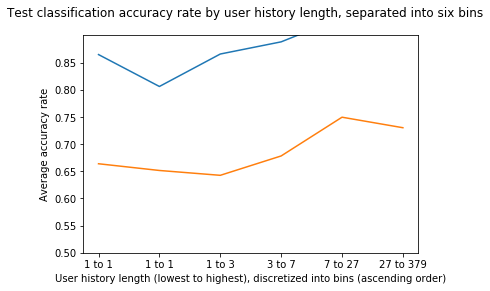

Strating ************************************************* 8
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.415
[1,   600] loss: 0.388
[1,   800] loss: 0.428
[1,  1000] loss: 0.335
[1,  1200] loss: 0.412
[1,  1400] loss: 0.361
[1,  1600] loss: 0.412
[1,  1800] loss: 0.415
[1,  2000] loss: 0.368
[1,  2200] loss: 0.437
[1,  2400] loss: 0.292
[1,  2600] loss: 0.424
[1,  2800] loss: 0.249
[1,  3000] loss: 0.402
[1,  3200] loss: 0.347
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.150
[2,   400] loss: 0.237
[2,   600] loss: 0.154
[2,   800] loss: 0.167
[2,  1000] loss: 0.175
[2,  1200] loss: 0.185
[2,  1400] loss: 0.229
[2,  1600] loss: 0.212
[2,  1800] loss: 0.203
[2,  2000] loss: 0.111
[2,  2200] loss: 0.174
[2,  2400] loss: 0.152
[2,  2600] loss: 0.165
[2,  2800] loss: 0.161
[2,  3000] loss: 0.183
[2,  3200] loss: 0.173
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.070
[3,   400] loss: 0.072
[3,   600] loss: 

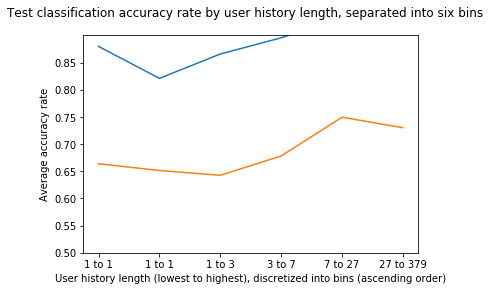

Strating ************************************************* 9
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.466
[1,   400] loss: 0.410
[1,   600] loss: 0.390
[1,   800] loss: 0.442
[1,  1000] loss: 0.349
[1,  1200] loss: 0.430
[1,  1400] loss: 0.354
[1,  1600] loss: 0.429
[1,  1800] loss: 0.423
[1,  2000] loss: 0.372
[1,  2200] loss: 0.448
[1,  2400] loss: 0.298
[1,  2600] loss: 0.409
[1,  2800] loss: 0.262
[1,  3000] loss: 0.402
[1,  3200] loss: 0.358
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.172
[2,   400] loss: 0.245
[2,   600] loss: 0.153
[2,   800] loss: 0.168
[2,  1000] loss: 0.180
[2,  1200] loss: 0.192
[2,  1400] loss: 0.242
[2,  1600] loss: 0.207
[2,  1800] loss: 0.217
[2,  2000] loss: 0.114
[2,  2200] loss: 0.196
[2,  2400] loss: 0.150
[2,  2600] loss: 0.152
[2,  2800] loss: 0.168
[2,  3000] loss: 0.185
[2,  3200] loss: 0.181
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.073
[3,   400] loss: 0.079
[3,   600] loss: 

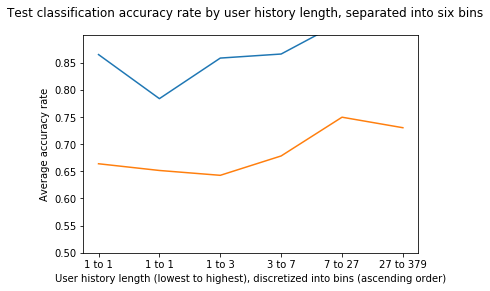

Strating ************************************************* 10
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.412
[1,   600] loss: 0.389
[1,   800] loss: 0.445
[1,  1000] loss: 0.343
[1,  1200] loss: 0.433
[1,  1400] loss: 0.366
[1,  1600] loss: 0.402
[1,  1800] loss: 0.437
[1,  2000] loss: 0.363
[1,  2200] loss: 0.423
[1,  2400] loss: 0.282
[1,  2600] loss: 0.397
[1,  2800] loss: 0.250
[1,  3000] loss: 0.414
[1,  3200] loss: 0.350
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.168
[2,   400] loss: 0.239
[2,   600] loss: 0.165
[2,   800] loss: 0.189
[2,  1000] loss: 0.175
[2,  1200] loss: 0.187
[2,  1400] loss: 0.221
[2,  1600] loss: 0.240
[2,  1800] loss: 0.196
[2,  2000] loss: 0.116
[2,  2200] loss: 0.178
[2,  2400] loss: 0.145
[2,  2600] loss: 0.162
[2,  2800] loss: 0.177
[2,  3000] loss: 0.188
[2,  3200] loss: 0.171
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.088
[3,   400] loss: 0.069
[3,   600] loss:

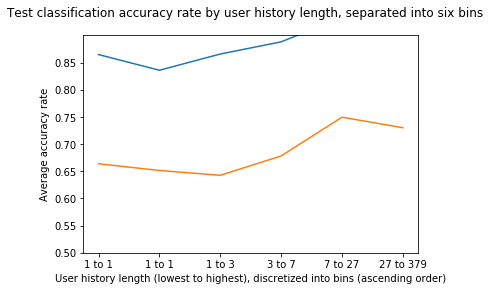

Strating ************************************************* 11
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.408
[1,   600] loss: 0.377
[1,   800] loss: 0.445
[1,  1000] loss: 0.345
[1,  1200] loss: 0.415
[1,  1400] loss: 0.362
[1,  1600] loss: 0.421
[1,  1800] loss: 0.434
[1,  2000] loss: 0.357
[1,  2200] loss: 0.449
[1,  2400] loss: 0.285
[1,  2600] loss: 0.403
[1,  2800] loss: 0.248
[1,  3000] loss: 0.393
[1,  3200] loss: 0.353
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.148
[2,   400] loss: 0.235
[2,   600] loss: 0.134
[2,   800] loss: 0.158
[2,  1000] loss: 0.165
[2,  1200] loss: 0.197
[2,  1400] loss: 0.220
[2,  1600] loss: 0.220
[2,  1800] loss: 0.205
[2,  2000] loss: 0.116
[2,  2200] loss: 0.184
[2,  2400] loss: 0.151
[2,  2600] loss: 0.149
[2,  2800] loss: 0.150
[2,  3000] loss: 0.189
[2,  3200] loss: 0.187
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.080
[3,   400] loss: 0.071
[3,   600] loss:

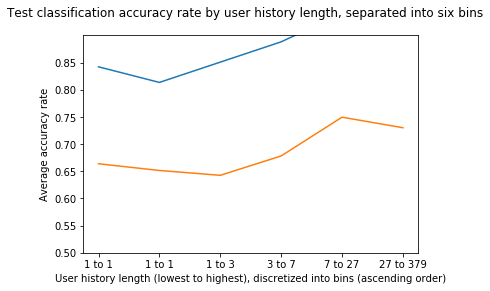

Strating ************************************************* 12
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.465
[1,   400] loss: 0.417
[1,   600] loss: 0.379
[1,   800] loss: 0.437
[1,  1000] loss: 0.341
[1,  1200] loss: 0.434
[1,  1400] loss: 0.378
[1,  1600] loss: 0.397
[1,  1800] loss: 0.433
[1,  2000] loss: 0.366
[1,  2200] loss: 0.459
[1,  2400] loss: 0.301
[1,  2600] loss: 0.423
[1,  2800] loss: 0.260
[1,  3000] loss: 0.388
[1,  3200] loss: 0.342
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.150
[2,   400] loss: 0.237
[2,   600] loss: 0.166
[2,   800] loss: 0.169
[2,  1000] loss: 0.168
[2,  1200] loss: 0.195
[2,  1400] loss: 0.208
[2,  1600] loss: 0.206
[2,  1800] loss: 0.202
[2,  2000] loss: 0.114
[2,  2200] loss: 0.193
[2,  2400] loss: 0.150
[2,  2600] loss: 0.141
[2,  2800] loss: 0.161
[2,  3000] loss: 0.174
[2,  3200] loss: 0.169
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.086
[3,   400] loss: 0.073
[3,   600] loss:

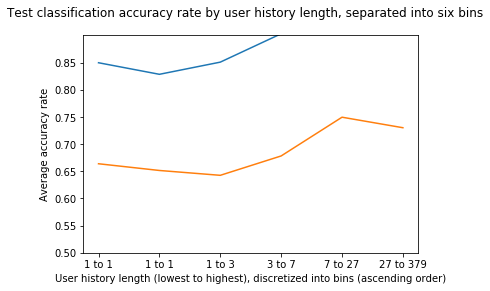

Strating ************************************************* 13
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.461
[1,   400] loss: 0.414
[1,   600] loss: 0.394
[1,   800] loss: 0.447
[1,  1000] loss: 0.347
[1,  1200] loss: 0.430
[1,  1400] loss: 0.355
[1,  1600] loss: 0.410
[1,  1800] loss: 0.435
[1,  2000] loss: 0.361
[1,  2200] loss: 0.444
[1,  2400] loss: 0.302
[1,  2600] loss: 0.418
[1,  2800] loss: 0.255
[1,  3000] loss: 0.387
[1,  3200] loss: 0.369
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.173
[2,   400] loss: 0.232
[2,   600] loss: 0.154
[2,   800] loss: 0.166
[2,  1000] loss: 0.171
[2,  1200] loss: 0.196
[2,  1400] loss: 0.212
[2,  1600] loss: 0.233
[2,  1800] loss: 0.206
[2,  2000] loss: 0.112
[2,  2200] loss: 0.195
[2,  2400] loss: 0.152
[2,  2600] loss: 0.154
[2,  2800] loss: 0.165
[2,  3000] loss: 0.173
[2,  3200] loss: 0.185
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.081
[3,   400] loss: 0.080
[3,   600] loss:

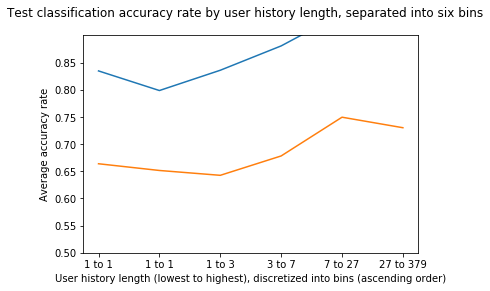

Strating ************************************************* 14
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.464
[1,   400] loss: 0.414
[1,   600] loss: 0.384
[1,   800] loss: 0.442
[1,  1000] loss: 0.338
[1,  1200] loss: 0.430
[1,  1400] loss: 0.370
[1,  1600] loss: 0.409
[1,  1800] loss: 0.444
[1,  2000] loss: 0.364
[1,  2200] loss: 0.451
[1,  2400] loss: 0.299
[1,  2600] loss: 0.400
[1,  2800] loss: 0.253
[1,  3000] loss: 0.384
[1,  3200] loss: 0.352
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.166
[2,   400] loss: 0.249
[2,   600] loss: 0.154
[2,   800] loss: 0.157
[2,  1000] loss: 0.171
[2,  1200] loss: 0.206
[2,  1400] loss: 0.222
[2,  1600] loss: 0.211
[2,  1800] loss: 0.202
[2,  2000] loss: 0.116
[2,  2200] loss: 0.211
[2,  2400] loss: 0.151
[2,  2600] loss: 0.163
[2,  2800] loss: 0.147
[2,  3000] loss: 0.186
[2,  3200] loss: 0.178
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.077
[3,   400] loss: 0.063
[3,   600] loss:

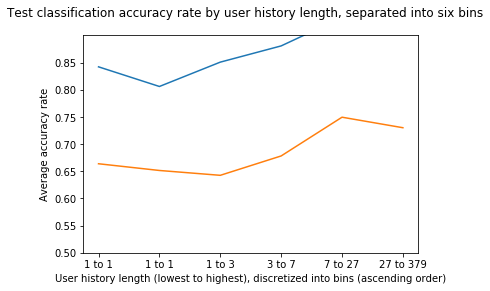

Strating ************************************************* 15
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.463
[1,   400] loss: 0.408
[1,   600] loss: 0.382
[1,   800] loss: 0.432
[1,  1000] loss: 0.348
[1,  1200] loss: 0.426
[1,  1400] loss: 0.365
[1,  1600] loss: 0.415
[1,  1800] loss: 0.432
[1,  2000] loss: 0.373
[1,  2200] loss: 0.453
[1,  2400] loss: 0.295
[1,  2600] loss: 0.403
[1,  2800] loss: 0.254
[1,  3000] loss: 0.398
[1,  3200] loss: 0.354
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.137
[2,   400] loss: 0.223
[2,   600] loss: 0.162
[2,   800] loss: 0.151
[2,  1000] loss: 0.176
[2,  1200] loss: 0.183
[2,  1400] loss: 0.219
[2,  1600] loss: 0.220
[2,  1800] loss: 0.204
[2,  2000] loss: 0.115
[2,  2200] loss: 0.186
[2,  2400] loss: 0.141
[2,  2600] loss: 0.163
[2,  2800] loss: 0.171
[2,  3000] loss: 0.170
[2,  3200] loss: 0.186
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.076
[3,   400] loss: 0.065
[3,   600] loss:

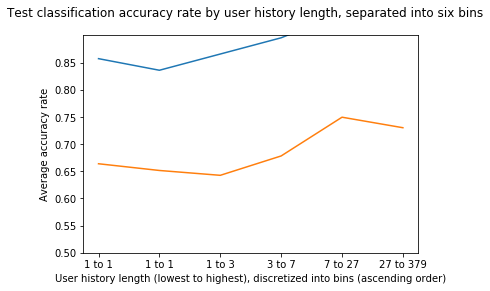

Strating ************************************************* 16
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.464
[1,   400] loss: 0.413
[1,   600] loss: 0.378
[1,   800] loss: 0.437
[1,  1000] loss: 0.325
[1,  1200] loss: 0.441
[1,  1400] loss: 0.363
[1,  1600] loss: 0.418
[1,  1800] loss: 0.438
[1,  2000] loss: 0.380
[1,  2200] loss: 0.446
[1,  2400] loss: 0.299
[1,  2600] loss: 0.430
[1,  2800] loss: 0.250
[1,  3000] loss: 0.402
[1,  3200] loss: 0.345
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.156
[2,   400] loss: 0.220
[2,   600] loss: 0.161
[2,   800] loss: 0.153
[2,  1000] loss: 0.166
[2,  1200] loss: 0.180
[2,  1400] loss: 0.207
[2,  1600] loss: 0.223
[2,  1800] loss: 0.227
[2,  2000] loss: 0.125
[2,  2200] loss: 0.208
[2,  2400] loss: 0.154
[2,  2600] loss: 0.160
[2,  2800] loss: 0.164
[2,  3000] loss: 0.188
[2,  3200] loss: 0.199
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.076
[3,   400] loss: 0.072
[3,   600] loss:

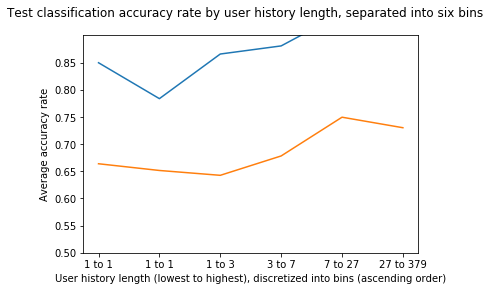

Strating ************************************************* 17
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.417
[1,   600] loss: 0.383
[1,   800] loss: 0.437
[1,  1000] loss: 0.339
[1,  1200] loss: 0.414
[1,  1400] loss: 0.371
[1,  1600] loss: 0.409
[1,  1800] loss: 0.451
[1,  2000] loss: 0.365
[1,  2200] loss: 0.438
[1,  2400] loss: 0.284
[1,  2600] loss: 0.417
[1,  2800] loss: 0.252
[1,  3000] loss: 0.392
[1,  3200] loss: 0.342
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.149
[2,   400] loss: 0.226
[2,   600] loss: 0.163
[2,   800] loss: 0.149
[2,  1000] loss: 0.182
[2,  1200] loss: 0.213
[2,  1400] loss: 0.216
[2,  1600] loss: 0.199
[2,  1800] loss: 0.206
[2,  2000] loss: 0.117
[2,  2200] loss: 0.181
[2,  2400] loss: 0.150
[2,  2600] loss: 0.145
[2,  2800] loss: 0.170
[2,  3000] loss: 0.200
[2,  3200] loss: 0.172
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.085
[3,   400] loss: 0.066
[3,   600] loss:

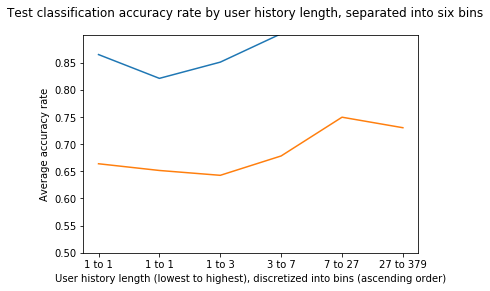

Strating ************************************************* 18
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.463
[1,   400] loss: 0.400
[1,   600] loss: 0.388
[1,   800] loss: 0.446
[1,  1000] loss: 0.335
[1,  1200] loss: 0.433
[1,  1400] loss: 0.383
[1,  1600] loss: 0.404
[1,  1800] loss: 0.434
[1,  2000] loss: 0.363
[1,  2200] loss: 0.428
[1,  2400] loss: 0.283
[1,  2600] loss: 0.398
[1,  2800] loss: 0.258
[1,  3000] loss: 0.403
[1,  3200] loss: 0.353
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.160
[2,   400] loss: 0.229
[2,   600] loss: 0.142
[2,   800] loss: 0.152
[2,  1000] loss: 0.141
[2,  1200] loss: 0.193
[2,  1400] loss: 0.226
[2,  1600] loss: 0.225
[2,  1800] loss: 0.197
[2,  2000] loss: 0.116
[2,  2200] loss: 0.193
[2,  2400] loss: 0.143
[2,  2600] loss: 0.153
[2,  2800] loss: 0.147
[2,  3000] loss: 0.191
[2,  3200] loss: 0.171
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.072
[3,   400] loss: 0.067
[3,   600] loss:

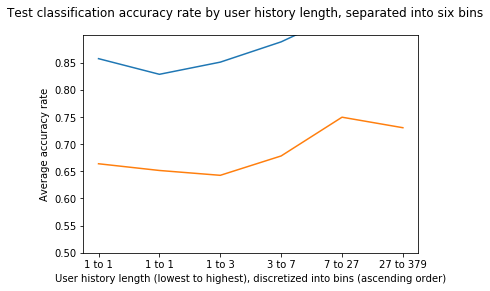

Strating ************************************************* 19
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.461
[1,   400] loss: 0.407
[1,   600] loss: 0.382
[1,   800] loss: 0.443
[1,  1000] loss: 0.346
[1,  1200] loss: 0.420
[1,  1400] loss: 0.364
[1,  1600] loss: 0.404
[1,  1800] loss: 0.456
[1,  2000] loss: 0.361
[1,  2200] loss: 0.437
[1,  2400] loss: 0.293
[1,  2600] loss: 0.427
[1,  2800] loss: 0.259
[1,  3000] loss: 0.384
[1,  3200] loss: 0.355
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.151
[2,   400] loss: 0.220
[2,   600] loss: 0.164
[2,   800] loss: 0.170
[2,  1000] loss: 0.175
[2,  1200] loss: 0.190
[2,  1400] loss: 0.223
[2,  1600] loss: 0.210
[2,  1800] loss: 0.218
[2,  2000] loss: 0.117
[2,  2200] loss: 0.194
[2,  2400] loss: 0.140
[2,  2600] loss: 0.147
[2,  2800] loss: 0.158
[2,  3000] loss: 0.173
[2,  3200] loss: 0.190
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.082
[3,   400] loss: 0.072
[3,   600] loss:

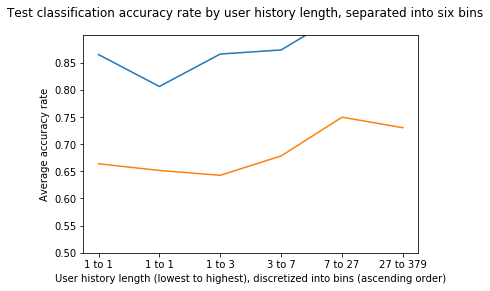

Strating ************************************************* 20
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.457
[1,   400] loss: 0.414
[1,   600] loss: 0.386
[1,   800] loss: 0.440
[1,  1000] loss: 0.338
[1,  1200] loss: 0.442
[1,  1400] loss: 0.380
[1,  1600] loss: 0.406
[1,  1800] loss: 0.436
[1,  2000] loss: 0.365
[1,  2200] loss: 0.429
[1,  2400] loss: 0.282
[1,  2600] loss: 0.401
[1,  2800] loss: 0.249
[1,  3000] loss: 0.394
[1,  3200] loss: 0.351
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.152
[2,   400] loss: 0.238
[2,   600] loss: 0.147
[2,   800] loss: 0.169
[2,  1000] loss: 0.169
[2,  1200] loss: 0.217
[2,  1400] loss: 0.230
[2,  1600] loss: 0.227
[2,  1800] loss: 0.206
[2,  2000] loss: 0.118
[2,  2200] loss: 0.183
[2,  2400] loss: 0.150
[2,  2600] loss: 0.162
[2,  2800] loss: 0.149
[2,  3000] loss: 0.205
[2,  3200] loss: 0.168
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.067
[3,   400] loss: 0.080
[3,   600] loss:

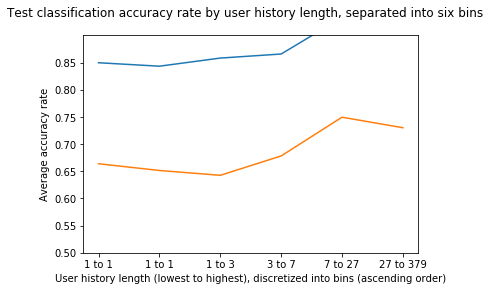

Strating ************************************************* 21
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.456
[1,   400] loss: 0.415
[1,   600] loss: 0.383
[1,   800] loss: 0.438
[1,  1000] loss: 0.341
[1,  1200] loss: 0.428
[1,  1400] loss: 0.359
[1,  1600] loss: 0.408
[1,  1800] loss: 0.445
[1,  2000] loss: 0.350
[1,  2200] loss: 0.439
[1,  2400] loss: 0.308
[1,  2600] loss: 0.405
[1,  2800] loss: 0.271
[1,  3000] loss: 0.372
[1,  3200] loss: 0.362
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.147
[2,   400] loss: 0.220
[2,   600] loss: 0.151
[2,   800] loss: 0.154
[2,  1000] loss: 0.159
[2,  1200] loss: 0.185
[2,  1400] loss: 0.195
[2,  1600] loss: 0.220
[2,  1800] loss: 0.197
[2,  2000] loss: 0.113
[2,  2200] loss: 0.180
[2,  2400] loss: 0.152
[2,  2600] loss: 0.142
[2,  2800] loss: 0.152
[2,  3000] loss: 0.197
[2,  3200] loss: 0.166
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.079
[3,   400] loss: 0.068
[3,   600] loss:

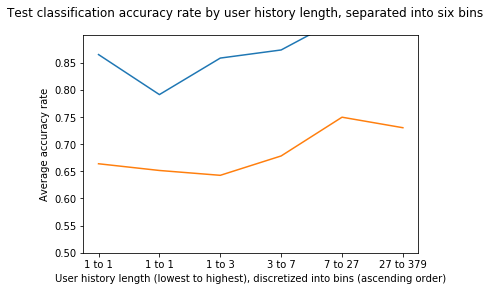

Strating ************************************************* 22
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.458
[1,   400] loss: 0.414
[1,   600] loss: 0.383
[1,   800] loss: 0.436
[1,  1000] loss: 0.345
[1,  1200] loss: 0.410
[1,  1400] loss: 0.370
[1,  1600] loss: 0.399
[1,  1800] loss: 0.434
[1,  2000] loss: 0.360
[1,  2200] loss: 0.441
[1,  2400] loss: 0.293
[1,  2600] loss: 0.406
[1,  2800] loss: 0.258
[1,  3000] loss: 0.421
[1,  3200] loss: 0.349
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.148
[2,   400] loss: 0.239
[2,   600] loss: 0.141
[2,   800] loss: 0.159
[2,  1000] loss: 0.169
[2,  1200] loss: 0.196
[2,  1400] loss: 0.198
[2,  1600] loss: 0.215
[2,  1800] loss: 0.196
[2,  2000] loss: 0.114
[2,  2200] loss: 0.176
[2,  2400] loss: 0.139
[2,  2600] loss: 0.148
[2,  2800] loss: 0.138
[2,  3000] loss: 0.182
[2,  3200] loss: 0.181
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.075
[3,   400] loss: 0.074
[3,   600] loss:

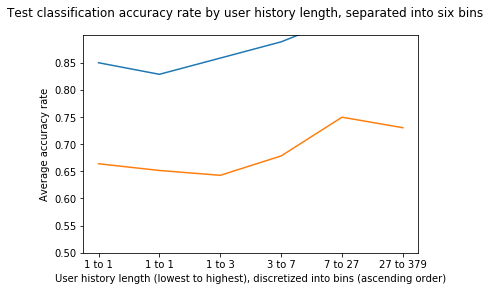

Strating ************************************************* 23
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.459
[1,   400] loss: 0.419
[1,   600] loss: 0.376
[1,   800] loss: 0.435
[1,  1000] loss: 0.341
[1,  1200] loss: 0.427
[1,  1400] loss: 0.362
[1,  1600] loss: 0.419
[1,  1800] loss: 0.434
[1,  2000] loss: 0.359
[1,  2200] loss: 0.443
[1,  2400] loss: 0.298
[1,  2600] loss: 0.430
[1,  2800] loss: 0.245
[1,  3000] loss: 0.386
[1,  3200] loss: 0.350
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.147
[2,   400] loss: 0.237
[2,   600] loss: 0.155
[2,   800] loss: 0.143
[2,  1000] loss: 0.159
[2,  1200] loss: 0.187
[2,  1400] loss: 0.203
[2,  1600] loss: 0.229
[2,  1800] loss: 0.191
[2,  2000] loss: 0.110
[2,  2200] loss: 0.186
[2,  2400] loss: 0.143
[2,  2600] loss: 0.153
[2,  2800] loss: 0.143
[2,  3000] loss: 0.181
[2,  3200] loss: 0.174
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.074
[3,   400] loss: 0.071
[3,   600] loss:

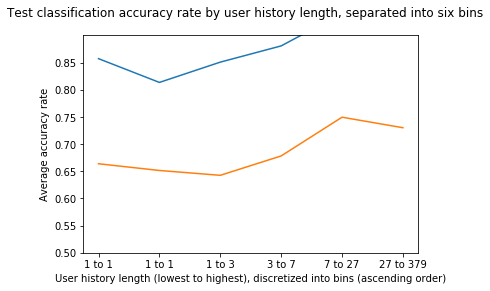

Strating ************************************************* 24
epoch: 0 learning rate: [0.013912384828252015]
[1,   200] loss: 0.463
[1,   400] loss: 0.413
[1,   600] loss: 0.386
[1,   800] loss: 0.444
[1,  1000] loss: 0.341
[1,  1200] loss: 0.424
[1,  1400] loss: 0.350
[1,  1600] loss: 0.406
[1,  1800] loss: 0.436
[1,  2000] loss: 0.357
[1,  2200] loss: 0.425
[1,  2400] loss: 0.305
[1,  2600] loss: 0.416
[1,  2800] loss: 0.265
[1,  3000] loss: 0.428
[1,  3200] loss: 0.355
epoch: 1 learning rate: [0.004684358451704644]
[2,   200] loss: 0.162
[2,   400] loss: 0.241
[2,   600] loss: 0.158
[2,   800] loss: 0.158
[2,  1000] loss: 0.167
[2,  1200] loss: 0.198
[2,  1400] loss: 0.218
[2,  1600] loss: 0.215
[2,  1800] loss: 0.200
[2,  2000] loss: 0.136
[2,  2200] loss: 0.197
[2,  2400] loss: 0.161
[2,  2600] loss: 0.164
[2,  2800] loss: 0.163
[2,  3000] loss: 0.184
[2,  3200] loss: 0.191
epoch: 2 learning rate: [0.00157724318116161]
[3,   200] loss: 0.071
[3,   400] loss: 0.073
[3,   600] loss:

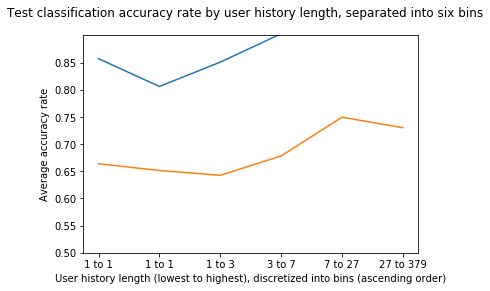

In [7]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_img_train, X_img_test)

Acc: 0.8798499999999998
AUC: 0.8757060786334554
F1: 0.928392232244946
Precision: 0.8987577315735186
Recall: 0.9600616332819721


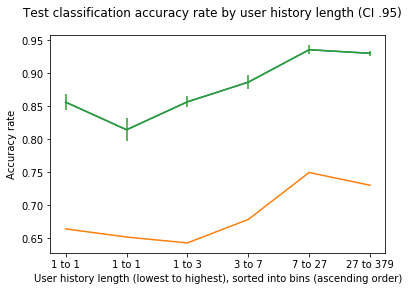

In [8]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [9]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [10]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [11]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# class labels
y_train = np.load(GLOVE_DIR + 'y_train.npy')
y_test= np.load(GLOVE_DIR + 'y_test.npy')

# load features
# img
X_histories_train_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_train.npy')
X_histories_test_img = np.load(NPY_INPUT_DIR + 'images_meanvecs_test.npy')

X_labeled_train_img = np.load(NPY_INPUT_DIR + 'images_nohistories_train.npy')
X_labeled_test_img = np.load(NPY_INPUT_DIR + 'images_nohistories_test.npy')

# lang
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')



X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')


scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

scaler5 = StandardScaler()
scaler6 = StandardScaler()


X_histories_train_img_norm = scaler5.fit_transform(X_histories_train_img)
X_histories_test_img_norm  = scaler5.transform(X_histories_test_img)
X_labeled_train_img_norm = scaler5.fit_transform(X_labeled_train_img)
X_labeled_test_img_norm  = scaler5.transform(X_labeled_test_img)
        
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


Strating ************************************************* 0
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.420
[1,   400] loss: 0.333
[1,   600] loss: 0.420
[1,   800] loss: 0.332
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.249
[2,   400] loss: 0.223
[2,   600] loss: 0.215
[2,   800] loss: 0.178
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.142
[3,   400] loss: 0.140
[3,   600] loss: 0.167
[3,   800] loss: 0.131
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.150
[4,   400] loss: 0.128
[4,   600] loss: 0.109
[4,   800] loss: 0.123
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

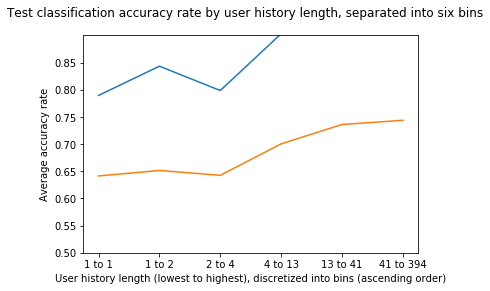

Strating ************************************************* 1
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.406
[1,   400] loss: 0.351
[1,   600] loss: 0.375
[1,   800] loss: 0.323
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.197
[2,   400] loss: 0.225
[2,   600] loss: 0.230
[2,   800] loss: 0.218
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.154
[3,   400] loss: 0.160
[3,   600] loss: 0.142
[3,   800] loss: 0.151
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.117
[4,   400] loss: 0.126
[4,   600] loss: 0.165
[4,   800] loss: 0.130
R2 score for bin 0 = -0.12448979591836751
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion o

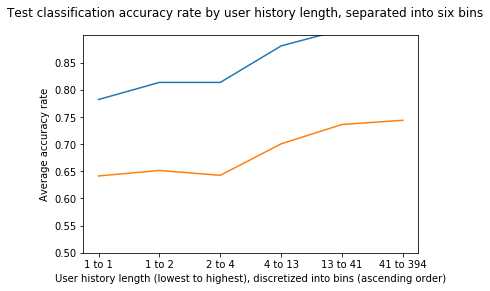

Strating ************************************************* 2
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.455
[1,   400] loss: 0.352
[1,   600] loss: 0.342
[1,   800] loss: 0.318
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.229
[2,   400] loss: 0.236
[2,   600] loss: 0.219
[2,   800] loss: 0.209
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.178
[3,   400] loss: 0.122
[3,   600] loss: 0.149
[3,   800] loss: 0.166
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.157
[4,   400] loss: 0.142
[4,   600] loss: 0.140
[4,   800] loss: 0.111
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + 

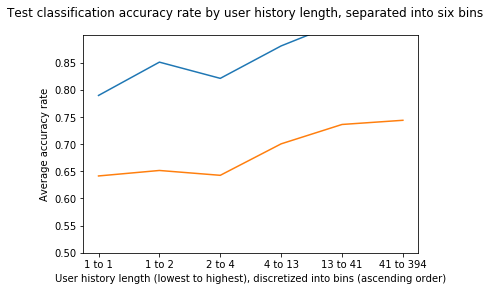

Strating ************************************************* 3
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.444
[1,   400] loss: 0.339
[1,   600] loss: 0.337
[1,   800] loss: 0.349
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.227
[2,   400] loss: 0.221
[2,   600] loss: 0.206
[2,   800] loss: 0.222
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.156
[3,   400] loss: 0.152
[3,   600] loss: 0.151
[3,   800] loss: 0.158
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.125
[4,   400] loss: 0.131
[4,   600] loss: 0.146
[4,   800] loss: 0.150
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = -0.12150072150072155
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

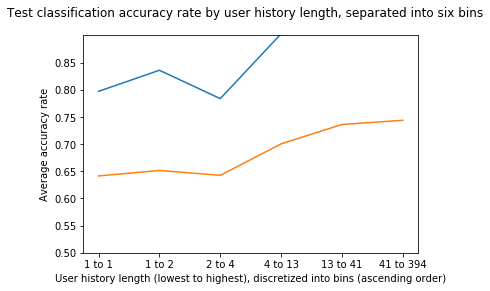

Strating ************************************************* 4
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.399
[1,   400] loss: 0.338
[1,   600] loss: 0.376
[1,   800] loss: 0.361
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.243
[2,   400] loss: 0.221
[2,   600] loss: 0.203
[2,   800] loss: 0.201
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.156
[3,   400] loss: 0.150
[3,   600] loss: 0.152
[3,   800] loss: 0.128
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.133
[4,   400] loss: 0.131
[4,   600] loss: 0.134
[4,   800] loss: 0.112
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of +

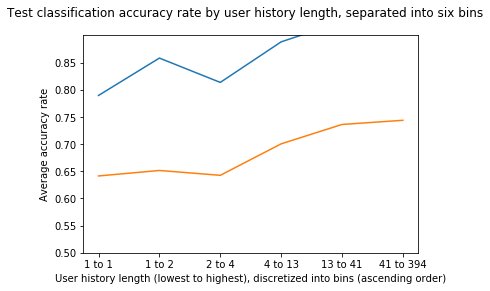

Strating ************************************************* 5
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.454
[1,   400] loss: 0.323
[1,   600] loss: 0.335
[1,   800] loss: 0.383
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.250
[2,   400] loss: 0.216
[2,   600] loss: 0.179
[2,   800] loss: 0.204
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.131
[3,   400] loss: 0.135
[3,   600] loss: 0.153
[3,   800] loss: 0.146
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.107
[4,   400] loss: 0.119
[4,   600] loss: 0.121
[4,   800] loss: 0.143
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of +

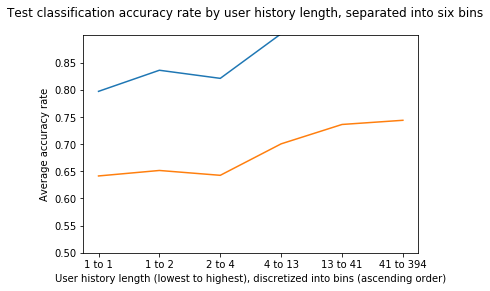

Strating ************************************************* 6
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.401
[1,   400] loss: 0.361
[1,   600] loss: 0.366
[1,   800] loss: 0.356
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.231
[2,   400] loss: 0.214
[2,   600] loss: 0.199
[2,   800] loss: 0.229
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.153
[3,   400] loss: 0.133
[3,   600] loss: 0.140
[3,   800] loss: 0.150
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.139
[4,   400] loss: 0.125
[4,   600] loss: 0.122
[4,   800] loss: 0.115
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

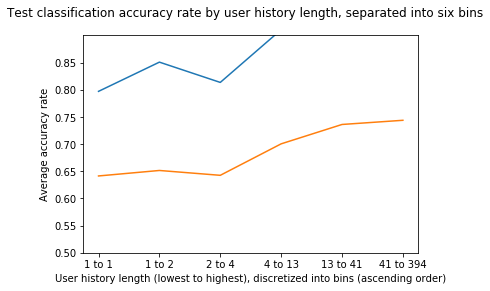

Strating ************************************************* 7
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.425
[1,   400] loss: 0.358
[1,   600] loss: 0.361
[1,   800] loss: 0.353
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.228
[2,   400] loss: 0.212
[2,   600] loss: 0.204
[2,   800] loss: 0.221
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.137
[3,   400] loss: 0.181
[3,   600] loss: 0.136
[3,   800] loss: 0.136
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.141
[4,   400] loss: 0.108
[4,   600] loss: 0.130
[4,   800] loss: 0.145
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of +

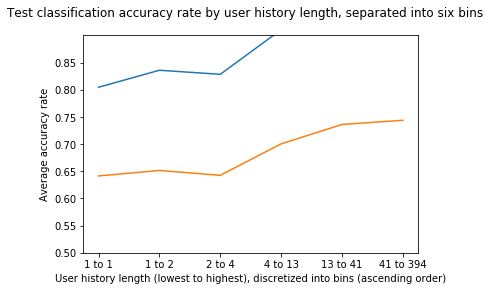

Strating ************************************************* 8
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.409
[1,   400] loss: 0.363
[1,   600] loss: 0.371
[1,   800] loss: 0.325
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.189
[2,   400] loss: 0.229
[2,   600] loss: 0.211
[2,   800] loss: 0.227
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.155
[3,   400] loss: 0.143
[3,   600] loss: 0.142
[3,   800] loss: 0.127
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.135
[4,   400] loss: 0.112
[4,   600] loss: 0.113
[4,   800] loss: 0.134
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = -0.0051005100510048695
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion o

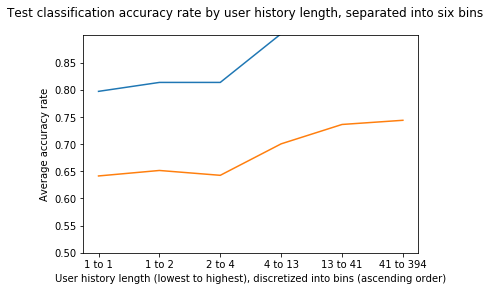

Strating ************************************************* 9
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.461
[1,   400] loss: 0.360
[1,   600] loss: 0.298
[1,   800] loss: 0.352
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.242
[2,   400] loss: 0.195
[2,   600] loss: 0.209
[2,   800] loss: 0.203
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.143
[3,   400] loss: 0.128
[3,   600] loss: 0.138
[3,   800] loss: 0.153
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.112
[4,   400] loss: 0.120
[4,   600] loss: 0.129
[4,   800] loss: 0.132
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of +

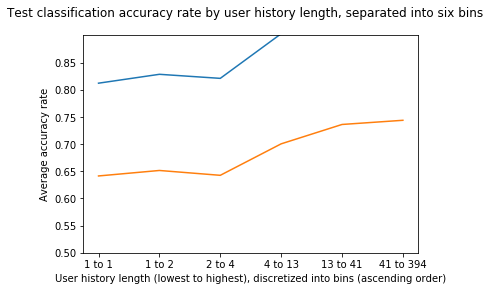

Strating ************************************************* 10
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.411
[1,   400] loss: 0.348
[1,   600] loss: 0.305
[1,   800] loss: 0.410
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.226
[2,   400] loss: 0.185
[2,   600] loss: 0.249
[2,   800] loss: 0.223
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.158
[3,   400] loss: 0.140
[3,   600] loss: 0.156
[3,   800] loss: 0.144
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.136
[4,   400] loss: 0.129
[4,   600] loss: 0.135
[4,   800] loss: 0.130
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.4561688311688311
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

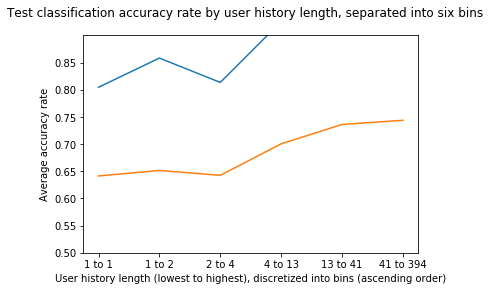

Strating ************************************************* 11
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.407
[1,   400] loss: 0.364
[1,   600] loss: 0.355
[1,   800] loss: 0.336
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.199
[2,   400] loss: 0.241
[2,   600] loss: 0.239
[2,   800] loss: 0.200
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.162
[3,   400] loss: 0.140
[3,   600] loss: 0.133
[3,   800] loss: 0.157
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.122
[4,   400] loss: 0.143
[4,   600] loss: 0.117
[4,   800] loss: 0.143
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = -0.036904761904761996
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

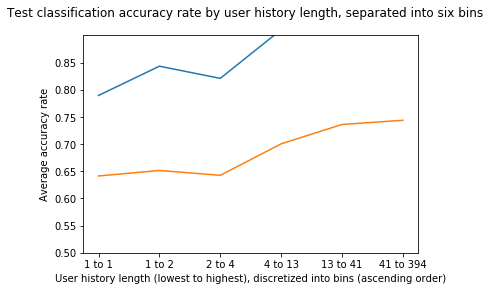

Strating ************************************************* 12
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.409
[1,   400] loss: 0.358
[1,   600] loss: 0.331
[1,   800] loss: 0.397
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.226
[2,   400] loss: 0.190
[2,   600] loss: 0.206
[2,   800] loss: 0.231
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.134
[3,   400] loss: 0.156
[3,   600] loss: 0.132
[3,   800] loss: 0.135
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.112
[4,   400] loss: 0.106
[4,   600] loss: 0.133
[4,   800] loss: 0.136
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of

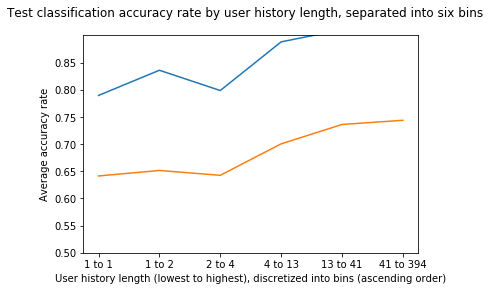

Strating ************************************************* 13
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.437
[1,   400] loss: 0.376
[1,   600] loss: 0.353
[1,   800] loss: 0.297
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.241
[2,   400] loss: 0.233
[2,   600] loss: 0.206
[2,   800] loss: 0.193
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.136
[3,   400] loss: 0.151
[3,   600] loss: 0.158
[3,   800] loss: 0.141
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.149
[4,   400] loss: 0.121
[4,   600] loss: 0.125
[4,   800] loss: 0.125
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.4017857142857143
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

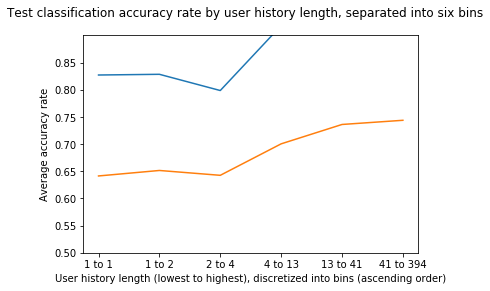

Strating ************************************************* 14
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.389
[1,   400] loss: 0.354
[1,   600] loss: 0.349
[1,   800] loss: 0.385
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.221
[2,   400] loss: 0.234
[2,   600] loss: 0.168
[2,   800] loss: 0.223
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.147
[3,   400] loss: 0.137
[3,   600] loss: 0.139
[3,   800] loss: 0.143
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.134
[4,   400] loss: 0.118
[4,   600] loss: 0.127
[4,   800] loss: 0.121
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.3165316531653166
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

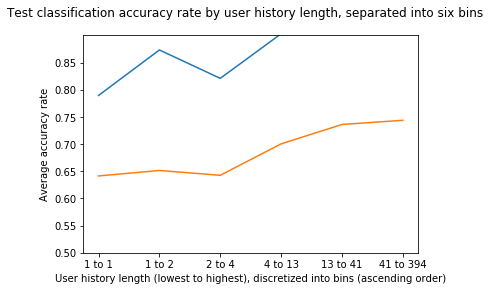

Strating ************************************************* 15
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.409
[1,   400] loss: 0.378
[1,   600] loss: 0.325
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.231
[2,   400] loss: 0.221
[2,   600] loss: 0.209
[2,   800] loss: 0.202
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.144
[3,   400] loss: 0.141
[3,   600] loss: 0.155
[3,   800] loss: 0.148
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.140
[4,   400] loss: 0.126
[4,   600] loss: 0.127
[4,   800] loss: 0.126
R2 score for bin 0 = -0.16326530612244916
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = -0.0054834054834054236
R2 score for bin 3 = 0.4017857142857143
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion o

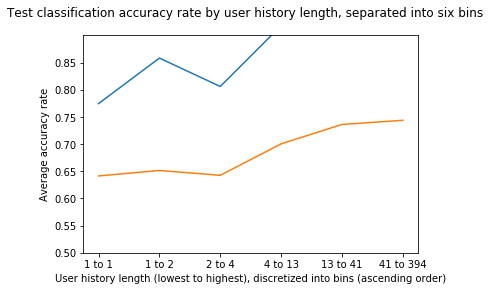

Strating ************************************************* 16
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.431
[1,   400] loss: 0.347
[1,   600] loss: 0.322
[1,   800] loss: 0.356
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.222
[2,   400] loss: 0.244
[2,   600] loss: 0.193
[2,   800] loss: 0.223
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.148
[3,   400] loss: 0.157
[3,   600] loss: 0.160
[3,   800] loss: 0.141
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.126
[4,   400] loss: 0.153
[4,   600] loss: 0.130
[4,   800] loss: 0.124
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.07530753075307539
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of +

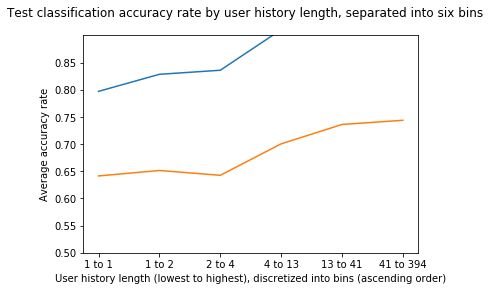

Strating ************************************************* 17
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.431
[1,   400] loss: 0.345
[1,   600] loss: 0.345
[1,   800] loss: 0.355
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.257
[2,   400] loss: 0.200
[2,   600] loss: 0.228
[2,   800] loss: 0.197
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.143
[3,   400] loss: 0.160
[3,   600] loss: 0.137
[3,   800] loss: 0.175
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.140
[4,   400] loss: 0.124
[4,   600] loss: 0.140
[4,   800] loss: 0.140
R2 score for bin 0 = -0.08571428571428608
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

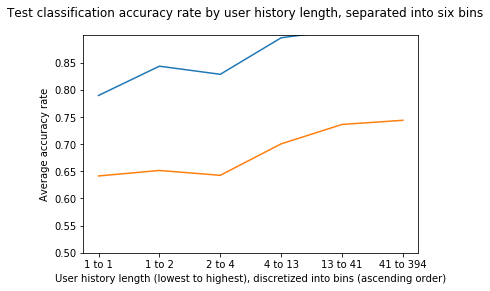

Strating ************************************************* 18
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.434
[1,   400] loss: 0.382
[1,   600] loss: 0.349
[1,   800] loss: 0.317
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.229
[2,   400] loss: 0.203
[2,   600] loss: 0.204
[2,   800] loss: 0.229
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.152
[3,   400] loss: 0.142
[3,   600] loss: 0.153
[3,   800] loss: 0.125
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.114
[4,   400] loss: 0.127
[4,   600] loss: 0.133
[4,   800] loss: 0.126
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

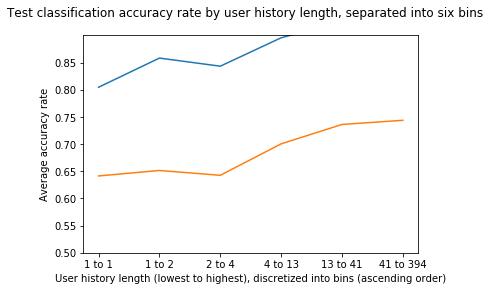

Strating ************************************************* 19
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.428
[1,   400] loss: 0.385
[1,   600] loss: 0.337
[1,   800] loss: 0.336
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.245
[2,   400] loss: 0.207
[2,   600] loss: 0.246
[2,   800] loss: 0.172
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.155
[3,   400] loss: 0.146
[3,   600] loss: 0.136
[3,   800] loss: 0.142
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.114
[4,   400] loss: 0.120
[4,   600] loss: 0.137
[4,   800] loss: 0.134
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

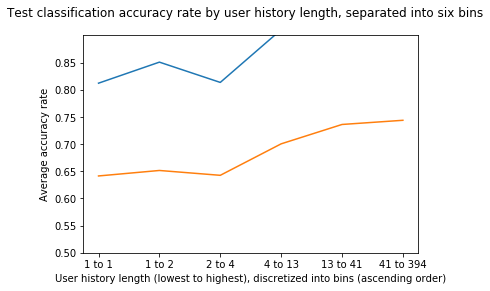

Strating ************************************************* 20
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.436
[1,   400] loss: 0.378
[1,   600] loss: 0.337
[1,   800] loss: 0.318
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.213
[2,   400] loss: 0.243
[2,   600] loss: 0.203
[2,   800] loss: 0.215
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.166
[3,   400] loss: 0.139
[3,   600] loss: 0.136
[3,   800] loss: 0.152
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.133
[4,   400] loss: 0.130
[4,   600] loss: 0.127
[4,   800] loss: 0.136
R2 score for bin 0 = -0.12448979591836751
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.29301948051948046
R2 score for bin 4 = -0.036904761904761996
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion o

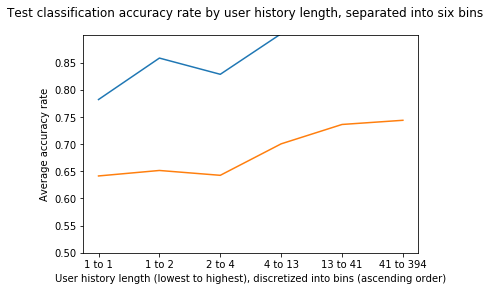

Strating ************************************************* 21
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.396
[1,   400] loss: 0.364
[1,   600] loss: 0.359
[1,   800] loss: 0.339
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.223
[2,   400] loss: 0.211
[2,   600] loss: 0.205
[2,   800] loss: 0.224
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.136
[3,   400] loss: 0.155
[3,   600] loss: 0.153
[3,   800] loss: 0.155
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.124
[4,   400] loss: 0.135
[4,   600] loss: 0.153
[4,   800] loss: 0.124
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.3578431372549019
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion o

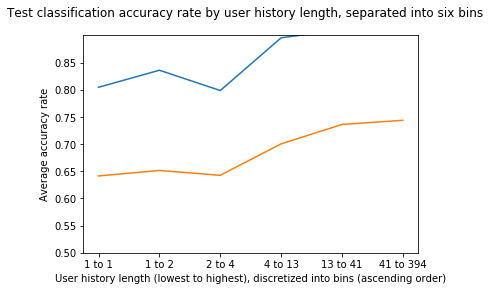

Strating ************************************************* 22
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.407
[1,   400] loss: 0.353
[1,   600] loss: 0.381
[1,   800] loss: 0.333
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.203
[2,   400] loss: 0.213
[2,   600] loss: 0.177
[2,   800] loss: 0.236
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.137
[3,   400] loss: 0.131
[3,   600] loss: 0.130
[3,   800] loss: 0.149
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.118
[4,   400] loss: 0.113
[4,   600] loss: 0.112
[4,   800] loss: 0.129
R2 score for bin 0 = -0.008163265306122769
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = -0.04415584415584428
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion 

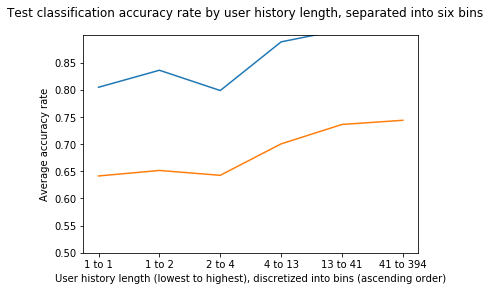

Strating ************************************************* 23
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.382
[1,   400] loss: 0.379
[1,   600] loss: 0.372
[1,   800] loss: 0.359
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.228
[2,   400] loss: 0.201
[2,   600] loss: 0.206
[2,   800] loss: 0.205
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.141
[3,   400] loss: 0.142
[3,   600] loss: 0.145
[3,   800] loss: 0.136
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.128
[4,   400] loss: 0.118
[4,   600] loss: 0.125
[4,   800] loss: 0.123
R2 score for bin 0 = -0.04693877551020442
R2 score for bin 1 = 0.3165316531653166
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = -0.036904761904761996
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

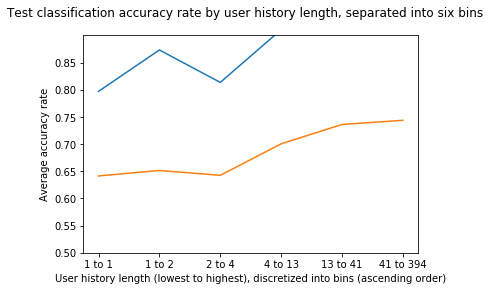

Strating ************************************************* 24
epoch: 0 learning rate: [0.02767144691683026]
[1,   200] loss: 0.394
[1,   400] loss: 0.350
[1,   600] loss: 0.356
[1,   800] loss: 0.373
epoch: 1 learning rate: [0.006497751193548555]
[2,   200] loss: 0.236
[2,   400] loss: 0.216
[2,   600] loss: 0.211
[2,   800] loss: 0.202
epoch: 2 learning rate: [0.0015257883225319258]
[3,   200] loss: 0.153
[3,   400] loss: 0.146
[3,   600] loss: 0.152
[3,   800] loss: 0.120
epoch: 3 learning rate: [0.0003582824173825288]
[4,   200] loss: 0.127
[4,   400] loss: 0.125
[4,   600] loss: 0.137
[4,   800] loss: 0.108
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.042857142857142816
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of 

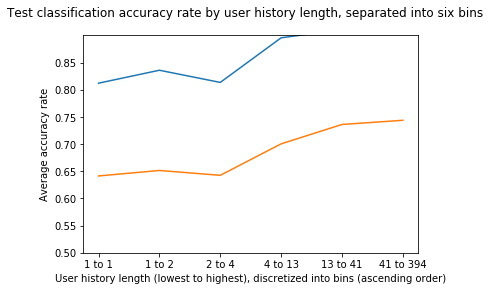

In [12]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.8681499999999999
AUC: 0.8570730313574627
F1: 0.9211468480406552
Precision: 0.8945962359893633
Recall: 0.949337442218798


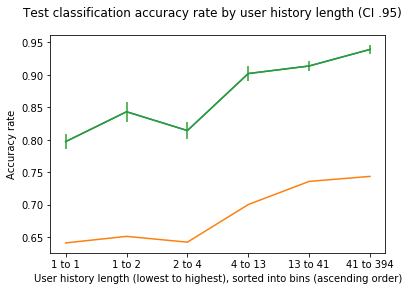

In [13]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [14]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        print('Strating *************************************************', i)
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [15]:
# merge data

# merge data
X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                      X_labeled_train_img_norm),
                     axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                     X_labeled_test_img_norm),
                    axis = 1)

Strating ************************************************* 0
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.524
[1,   400] loss: 0.497
[1,   600] loss: 0.396
[1,   800] loss: 0.387
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.267
[2,   400] loss: 0.286
[2,   600] loss: 0.259
[2,   800] loss: 0.301
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.199
[3,   400] loss: 0.224
[3,   600] loss: 0.230
[3,   800] loss: 0.254
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.205
[4,   400] loss: 0.218
[4,   600] loss: 0.176
[4,   800] loss: 0.221
R2 score for bin 0 = 0.10816326530612219
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.02110389610389607
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

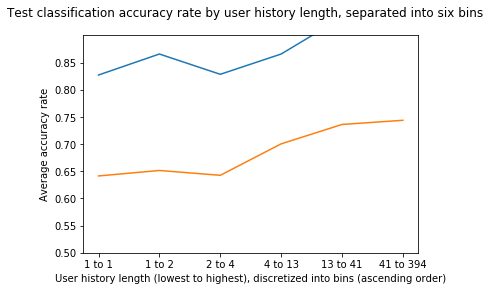

Strating ************************************************* 1
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.546
[1,   400] loss: 0.492
[1,   600] loss: 0.413
[1,   800] loss: 0.333
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.284
[2,   400] loss: 0.277
[2,   600] loss: 0.283
[2,   800] loss: 0.266
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.234
[3,   400] loss: 0.232
[3,   600] loss: 0.236
[3,   800] loss: 0.220
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.220
[4,   400] loss: 0.185
[4,   600] loss: 0.204
[4,   800] loss: 0.226
R2 score for bin 0 = 0.22448979591836715
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

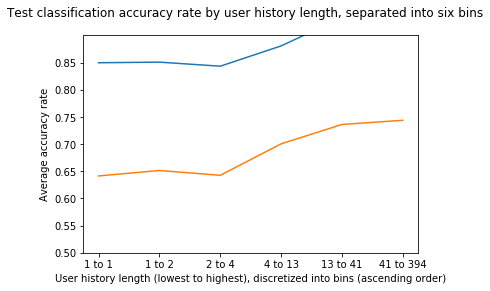

Strating ************************************************* 2
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.544
[1,   400] loss: 0.517
[1,   600] loss: 0.397
[1,   800] loss: 0.419
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.267
[2,   400] loss: 0.275
[2,   600] loss: 0.270
[2,   800] loss: 0.306
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.215
[3,   400] loss: 0.253
[3,   600] loss: 0.232
[3,   800] loss: 0.244
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.212
[4,   400] loss: 0.217
[4,   600] loss: 0.213
[4,   800] loss: 0.209
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.3165316531653166
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + score

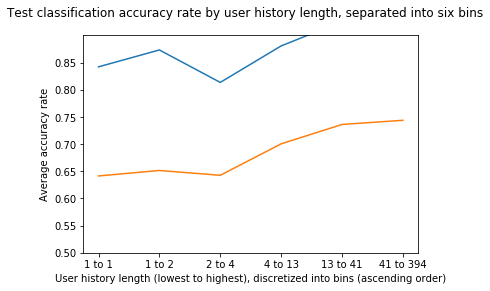

Strating ************************************************* 3
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.558
[1,   400] loss: 0.504
[1,   600] loss: 0.405
[1,   800] loss: 0.344
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.265
[2,   400] loss: 0.285
[2,   600] loss: 0.307
[2,   800] loss: 0.261
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.232
[3,   400] loss: 0.243
[3,   600] loss: 0.228
[3,   800] loss: 0.221
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.209
[4,   400] loss: 0.217
[4,   600] loss: 0.197
[4,   800] loss: 0.222
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

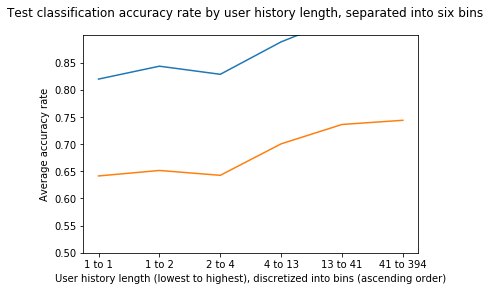

Strating ************************************************* 4
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.557
[1,   400] loss: 0.565
[1,   600] loss: 0.415
[1,   800] loss: 0.334
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.294
[2,   400] loss: 0.253
[2,   600] loss: 0.289
[2,   800] loss: 0.274
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.235
[3,   400] loss: 0.244
[3,   600] loss: 0.213
[3,   800] loss: 0.236
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.204
[4,   400] loss: 0.232
[4,   600] loss: 0.197
[4,   800] loss: 0.198
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

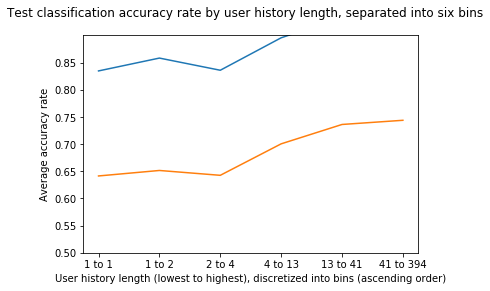

Strating ************************************************* 5
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.568
[1,   400] loss: 0.516
[1,   600] loss: 0.394
[1,   800] loss: 0.360
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.290
[2,   400] loss: 0.278
[2,   600] loss: 0.264
[2,   800] loss: 0.283
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.227
[3,   400] loss: 0.228
[3,   600] loss: 0.221
[3,   800] loss: 0.261
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.195
[4,   400] loss: 0.203
[4,   600] loss: 0.233
[4,   800] loss: 0.213
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

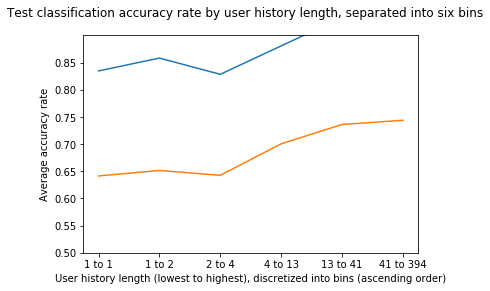

Strating ************************************************* 6
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.586
[1,   400] loss: 0.470
[1,   600] loss: 0.405
[1,   800] loss: 0.331
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.275
[2,   400] loss: 0.278
[2,   600] loss: 0.251
[2,   800] loss: 0.290
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.242
[3,   400] loss: 0.190
[3,   600] loss: 0.232
[3,   800] loss: 0.241
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.203
[4,   400] loss: 0.213
[4,   600] loss: 0.193
[4,   800] loss: 0.210
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

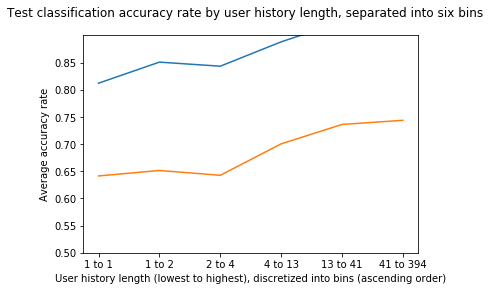

Strating ************************************************* 7
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.558
[1,   400] loss: 0.494
[1,   600] loss: 0.368
[1,   800] loss: 0.343
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.266
[2,   400] loss: 0.269
[2,   600] loss: 0.259
[2,   800] loss: 0.299
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.215
[3,   400] loss: 0.229
[3,   600] loss: 0.199
[3,   800] loss: 0.254
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.201
[4,   400] loss: 0.211
[4,   600] loss: 0.204
[4,   800] loss: 0.197
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.15571557155715587
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

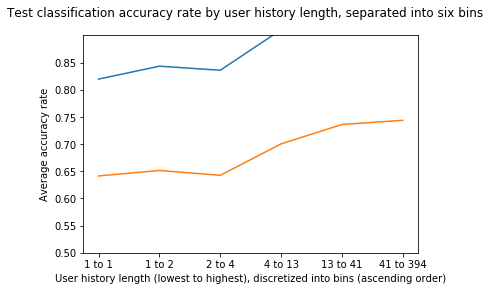

Strating ************************************************* 8
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.539
[1,   400] loss: 0.528
[1,   600] loss: 0.407
[1,   800] loss: 0.336
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.284
[2,   400] loss: 0.241
[2,   600] loss: 0.281
[2,   800] loss: 0.307
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.232
[3,   400] loss: 0.229
[3,   600] loss: 0.221
[3,   800] loss: 0.237
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.209
[4,   400] loss: 0.205
[4,   600] loss: 0.216
[4,   800] loss: 0.198
R2 score for bin 0 = 0.030612244897958996
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + 

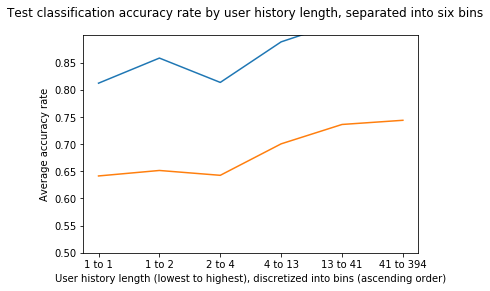

Strating ************************************************* 9
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.572
[1,   400] loss: 0.519
[1,   600] loss: 0.412
[1,   800] loss: 0.342
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.297
[2,   400] loss: 0.255
[2,   600] loss: 0.285
[2,   800] loss: 0.292
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.253
[3,   400] loss: 0.210
[3,   600] loss: 0.223
[3,   800] loss: 0.245
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.202
[4,   400] loss: 0.227
[4,   600] loss: 0.198
[4,   800] loss: 0.216
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

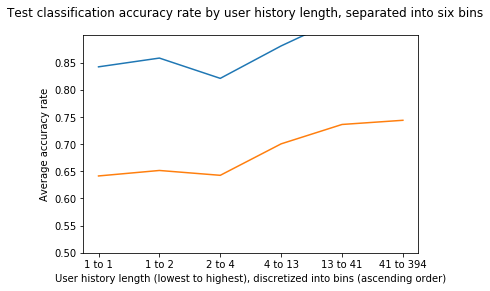

Strating ************************************************* 10
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.505
[1,   400] loss: 0.550
[1,   600] loss: 0.435
[1,   800] loss: 0.368
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.302
[2,   400] loss: 0.282
[2,   600] loss: 0.272
[2,   800] loss: 0.267
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.230
[3,   400] loss: 0.225
[3,   600] loss: 0.219
[3,   800] loss: 0.241
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.208
[4,   400] loss: 0.209
[4,   600] loss: 0.196
[4,   800] loss: 0.208
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.396939693969397
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.07548701298701299
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

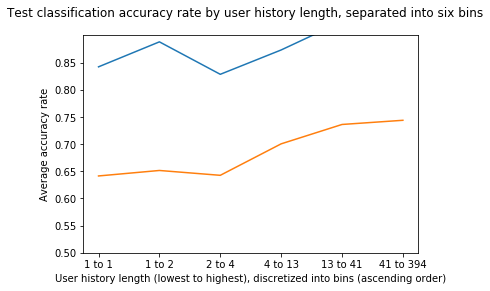

Strating ************************************************* 11
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.541
[1,   400] loss: 0.496
[1,   600] loss: 0.414
[1,   800] loss: 0.380
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.271
[2,   400] loss: 0.289
[2,   600] loss: 0.287
[2,   800] loss: 0.269
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.232
[3,   400] loss: 0.226
[3,   600] loss: 0.226
[3,   800] loss: 0.233
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.206
[4,   400] loss: 0.220
[4,   600] loss: 0.198
[4,   800] loss: 0.204
R2 score for bin 0 = 0.22448979591836715
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

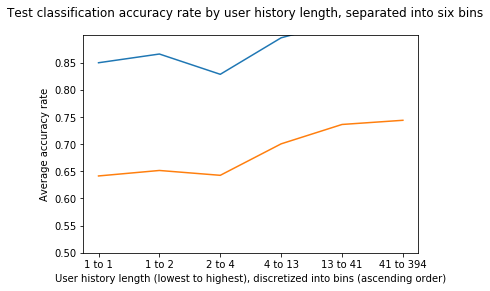

Strating ************************************************* 12
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.541
[1,   400] loss: 0.465
[1,   600] loss: 0.402
[1,   800] loss: 0.366
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.287
[2,   400] loss: 0.287
[2,   600] loss: 0.257
[2,   800] loss: 0.262
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.226
[3,   400] loss: 0.203
[3,   600] loss: 0.239
[3,   800] loss: 0.230
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.209
[4,   400] loss: 0.173
[4,   600] loss: 0.221
[4,   800] loss: 0.215
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.19591959195919606
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

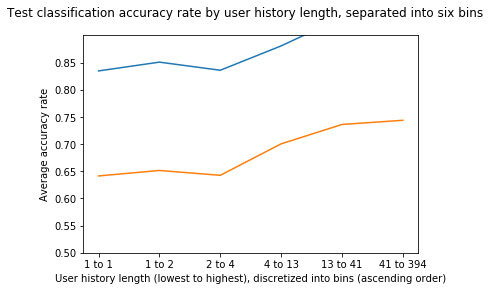

Strating ************************************************* 13
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.508
[1,   400] loss: 0.507
[1,   600] loss: 0.425
[1,   800] loss: 0.352
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.270
[2,   400] loss: 0.272
[2,   600] loss: 0.302
[2,   800] loss: 0.288
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.238
[3,   400] loss: 0.250
[3,   600] loss: 0.227
[3,   800] loss: 0.224
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.209
[4,   400] loss: 0.204
[4,   600] loss: 0.222
[4,   800] loss: 0.213
R2 score for bin 0 = 0.30204081632653046
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

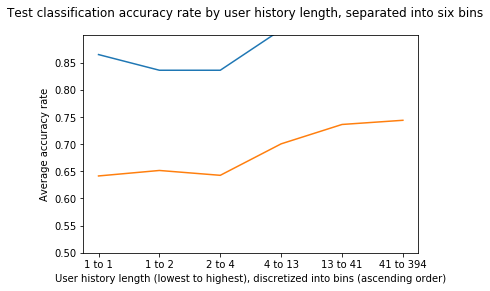

Strating ************************************************* 14
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.571
[1,   400] loss: 0.532
[1,   600] loss: 0.393
[1,   800] loss: 0.327
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.288
[2,   400] loss: 0.267
[2,   600] loss: 0.255
[2,   800] loss: 0.279
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.223
[3,   400] loss: 0.234
[3,   600] loss: 0.215
[3,   800] loss: 0.223
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.202
[4,   400] loss: 0.177
[4,   600] loss: 0.208
[4,   800] loss: 0.237
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

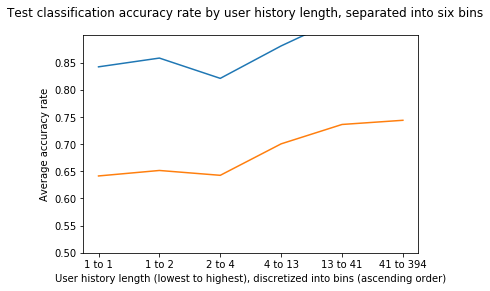

Strating ************************************************* 15
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.491
[1,   400] loss: 0.540
[1,   600] loss: 0.412
[1,   800] loss: 0.355
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.288
[2,   400] loss: 0.275
[2,   600] loss: 0.269
[2,   800] loss: 0.271
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.230
[3,   400] loss: 0.224
[3,   600] loss: 0.222
[3,   800] loss: 0.238
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.198
[4,   400] loss: 0.221
[4,   600] loss: 0.214
[4,   800] loss: 0.202
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.07186147186147185
R2 score for bin 3 = 0.3474025974025974
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

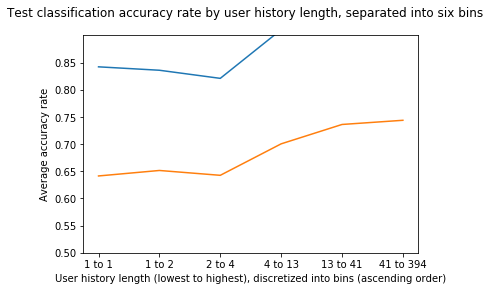

Strating ************************************************* 16
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.564
[1,   400] loss: 0.454
[1,   600] loss: 0.417
[1,   800] loss: 0.329
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.279
[2,   400] loss: 0.277
[2,   600] loss: 0.289
[2,   800] loss: 0.259
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.194
[3,   400] loss: 0.234
[3,   600] loss: 0.232
[3,   800] loss: 0.252
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.191
[4,   400] loss: 0.205
[4,   600] loss: 0.226
[4,   800] loss: 0.201
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + 

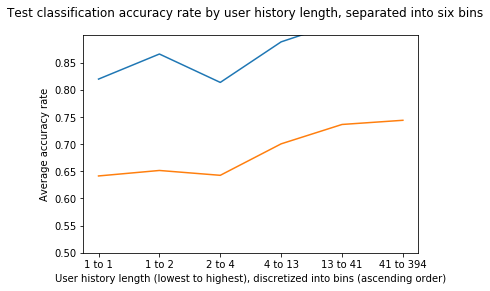

Strating ************************************************* 17
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.516
[1,   400] loss: 0.506
[1,   600] loss: 0.388
[1,   800] loss: 0.370
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.275
[2,   400] loss: 0.291
[2,   600] loss: 0.252
[2,   800] loss: 0.276
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.190
[3,   400] loss: 0.240
[3,   600] loss: 0.235
[3,   800] loss: 0.238
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.213
[4,   400] loss: 0.184
[4,   600] loss: 0.193
[4,   800] loss: 0.229
R2 score for bin 0 = 0.22448979591836715
R2 score for bin 1 = 0.11551155115511558
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.12261904761904752
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

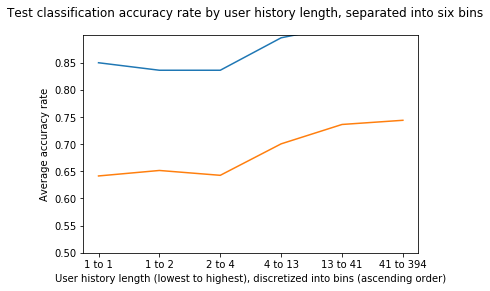

Strating ************************************************* 18
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.554
[1,   400] loss: 0.473
[1,   600] loss: 0.418
[1,   800] loss: 0.372
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.273
[2,   400] loss: 0.278
[2,   600] loss: 0.276
[2,   800] loss: 0.258
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.226
[3,   400] loss: 0.235
[3,   600] loss: 0.196
[3,   800] loss: 0.239
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.205
[4,   400] loss: 0.201
[4,   600] loss: 0.207
[4,   800] loss: 0.203
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.18425324675324672
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

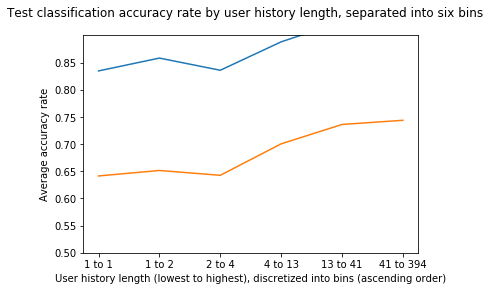

Strating ************************************************* 19
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.583
[1,   400] loss: 0.474
[1,   600] loss: 0.429
[1,   800] loss: 0.363
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.294
[2,   400] loss: 0.286
[2,   600] loss: 0.275
[2,   800] loss: 0.267
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.239
[3,   400] loss: 0.231
[3,   600] loss: 0.255
[3,   800] loss: 0.222
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.214
[4,   400] loss: 0.222
[4,   600] loss: 0.197
[4,   800] loss: 0.213
R2 score for bin 0 = 0.06938775510204065
R2 score for bin 1 = 0.3567356735673568
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.07548701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

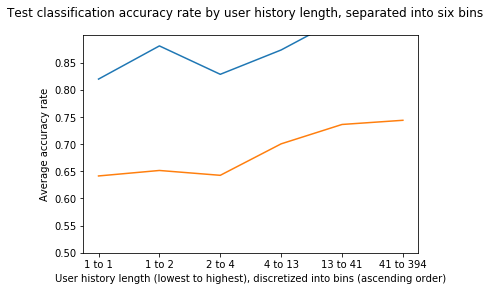

Strating ************************************************* 20
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.540
[1,   400] loss: 0.517
[1,   600] loss: 0.420
[1,   800] loss: 0.350
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.273
[2,   400] loss: 0.307
[2,   600] loss: 0.277
[2,   800] loss: 0.278
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.241
[3,   400] loss: 0.232
[3,   600] loss: 0.228
[3,   800] loss: 0.226
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.220
[4,   400] loss: 0.203
[4,   600] loss: 0.209
[4,   800] loss: 0.206
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.3165316531653166
R2 score for bin 2 = 0.18787878787878787
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.08263305322128855
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sco

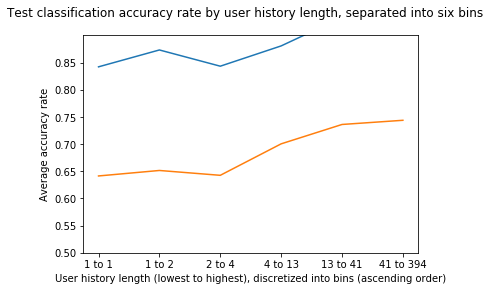

Strating ************************************************* 21
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.552
[1,   400] loss: 0.492
[1,   600] loss: 0.432
[1,   800] loss: 0.384
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.303
[2,   400] loss: 0.293
[2,   600] loss: 0.249
[2,   800] loss: 0.316
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.238
[3,   400] loss: 0.231
[3,   600] loss: 0.210
[3,   800] loss: 0.268
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.230
[4,   400] loss: 0.201
[4,   600] loss: 0.198
[4,   800] loss: 0.238
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.23612361236123625
R2 score for bin 2 = 0.03318903318903321
R2 score for bin 3 = 0.23863636363636365
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

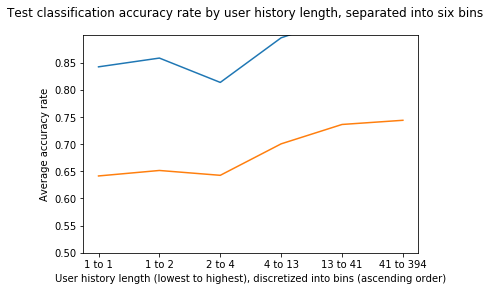

Strating ************************************************* 22
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.554
[1,   400] loss: 0.493
[1,   600] loss: 0.416
[1,   800] loss: 0.361
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.308
[2,   400] loss: 0.277
[2,   600] loss: 0.269
[2,   800] loss: 0.278
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.259
[3,   400] loss: 0.232
[3,   600] loss: 0.224
[3,   800] loss: 0.230
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.232
[4,   400] loss: 0.191
[4,   600] loss: 0.205
[4,   800] loss: 0.234
R2 score for bin 0 = 0.1857142857142855
R2 score for bin 1 = 0.3165316531653166
R2 score for bin 2 = 0.14920634920634923
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = 0.1743697478991597
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + scor

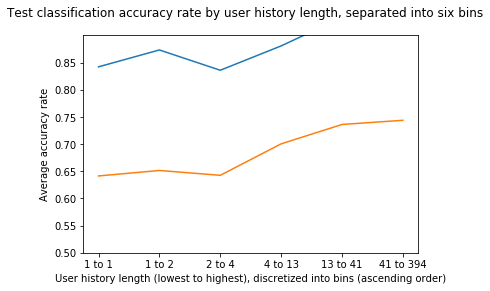

Strating ************************************************* 23
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.543
[1,   400] loss: 0.500
[1,   600] loss: 0.435
[1,   800] loss: 0.341
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.263
[2,   400] loss: 0.303
[2,   600] loss: 0.280
[2,   800] loss: 0.303
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.248
[3,   400] loss: 0.210
[3,   600] loss: 0.258
[3,   800] loss: 0.234
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.217
[4,   400] loss: 0.193
[4,   600] loss: 0.227
[4,   800] loss: 0.216
R2 score for bin 0 = 0.14693877551020385
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.28214285714285703
R2 score for bin 5 = -0.0091036414565826
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + s

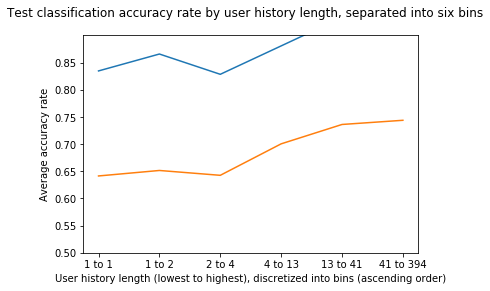

Strating ************************************************* 24
epoch: 0 learning rate: [0.01660885743965316]
[1,   200] loss: 0.560
[1,   400] loss: 0.521
[1,   600] loss: 0.418
[1,   800] loss: 0.343
epoch: 1 learning rate: [0.008425715156801992]
[2,   200] loss: 0.270
[2,   400] loss: 0.312
[2,   600] loss: 0.272
[2,   800] loss: 0.283
epoch: 2 learning rate: [0.004274386492960671]
[3,   200] loss: 0.219
[3,   400] loss: 0.223
[3,   600] loss: 0.241
[3,   800] loss: 0.243
epoch: 3 learning rate: [0.0021684070196053493]
[4,   200] loss: 0.203
[4,   400] loss: 0.204
[4,   600] loss: 0.231
[4,   800] loss: 0.207
R2 score for bin 0 = 0.2632653061224488
R2 score for bin 1 = 0.27632763276327643
R2 score for bin 2 = 0.11053391053391048
R2 score for bin 3 = 0.1298701298701299
R2 score for bin 4 = 0.20238095238095233
R2 score for bin 5 = 0.26610644257703076
True proportion of + scores in bin 0 = 0.7368421052631579
True proportion of + scores in bin 1 = 0.753731343283582
True proportion of + sc

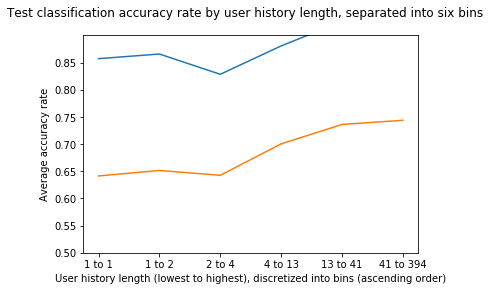

In [16]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)




Acc: 0.8780500000000001
AUC: 0.8914948111715426
F1: 0.9266642192318402
Precision: 0.9047185623338776
Recall: 0.9498921417565483


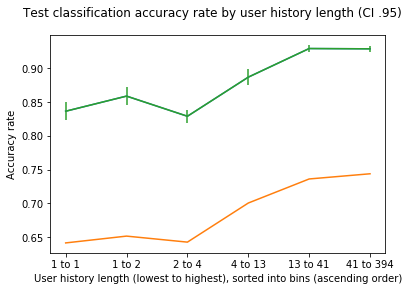

In [17]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)